In [1]:
from __future__ import division

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all" # Allow printing multiple outputs from each cell

In [2]:
# Dependency for the computations
import numpy as np

# Dependency only for the charts
import matplotlib.pyplot as plt
import seaborn as sns # Make matplotlib charts look better
sns.set(style='ticks')

# Dependency only for adding methods to classes dynamically in jupyter (Jupyter Dynamic Classes)
# See https://github.com/jupyter/notebook/issues/1243 and https://alexhagen.github.io/jdc/
import jdc

In [3]:
%matplotlib inline

A literate programming notebook written as I follow http://neuralnetworksanddeeplearning.com/chap1.html (as recommended in fast.ai course lesson 2 notes)

This is basically a 'My First Neural Network' notebook with (hopefully) copious documentation, built to learn NumPy and solidify the concepts for me before going back to using the higher-level libraries such as Keras/TensorFlow. It won't use GPU, and it isn't optimised for performance. It's just about checking I understand the concepts fully, and to explore the NumPy APIs.

The end goal (based on the chapter 1 content) is to build an entry for the Kaggle MNIST competition, using a neural network, written from scratch - and for that neural network to be general enough for other problems. 

# Perceptrons

A perceptron takes any number of binary inputs $x_0, x_1,..., x_n$ and outputs a single binary value. First we compute $\sum_j x_j w_j$, where each $w_j \in \mathbb{R}$ is a weight (and there are equal numbers of inputs $x_i$ and weights $w_i$). This is the dot product of the two vectors, $\mathbf{x} \cdot \mathbf{w}$, which we can compute using the `np.dot` method.

In [4]:
x = [0, 0, 1, 1, 0] # 5 binary inputs
w = [1, 2, 3, 4, 1] # 5 real-valued weights

dot = np.dot(x, w)
print(dot)

7


So for a perceptron we see that because of the binary-valued inputs, the output of $\mathbf{x} \cdot \mathbf{w}$ is simply the sum of weights $w_j$ where $x_j = 1$. 

As mentioned, the output of a perceptron is in fact binary-valued, and this is done using a threshold: If $\mathbf{x} \cdot \mathbf{w} \le threshold$ then the perceptron outputs 0, otherwise it outputs 1. 

We replace the threshold with bias $-b = threshold$, and move it to the other side of the inequality, such that we have: If $\mathbf{x} \cdot \mathbf{w} + b \le 0$ then the perceptron outputs 0, otherwise it outputs 1. 

So we could fully capture a perceptron's behaviour with a simple method:

In [5]:
def perceptron(x, w, bias):
    if np.dot(x, w) + bias <= 0:
        return 0
    else: 
        return 1

# For example, using our x and w from before
x = [0, 0, 1, 1, 0] 
w = [1, 2, 3, 4, 1] 
perceptron(x, w, bias=2)
perceptron(x, w, bias=-10)

1

0

In [6]:
# From the book, using the perceptron to implement NAND 
w = [-2, -2]
bias = 3

for x1, x2 in [(0,0), (0,1), (1,0), (1,1)]:
    perceptron([x1,x2], w, bias)

1

1

1

0

We can in fact use a perceptron to learn any linearly separable function, including NAND. To show this, let's consider how a perceptron learns. 

We start with randomly initialised weights and bias terms. We also pass in training data, in tuples of (input, output) ie (x, y). For a binary function this is ((x1, x2), y).

Then for each **epoch** (ie the number of times we want to learn), we take each training example, and using its input and our current weights we compute the current value of the perceptron on that input. We find the difference between the expected output `y` and the current output, the error term. Note that this must be computed `y - output` - the order matters. The error term will either be 0, 1 or -1. 

We adjust the weights in each position $w_i$ by $w_i += \eta * error * x_i$ ($\eta$, eta is just a learning rate that we can tweak - it changes how quickly the weights change for wrong examples.) We adjust the bias by $\eta * error$, since it's not linked to any input directly. 

Assuming the input training data is linearly separable this algorithm will converge to 100% accuracy in a finite number of epochs. 


To demonstrate this, we'll define a function to train a perceptron - and demonstrate it on the NAND case. 

In [7]:
def train_perceptron(training_data, epochs=30, eta=1):
    x_len = len(training_data[0][0]) # Tuples of ((xs...), y) - want len xs

    w = np.random.rand(x_len) # Random starting weights equal length to x_len, 0-1
    bias = np.random.rand() # Random starting bias, 0-1

    errors = {} # Count errors at each epoch

    for i in range(epochs):
        errors[i] = 0
        for x, y in training_data:
            output = perceptron(x, w, bias)
            error = y - output
            if error != 0:
                errors[i]+=1

            w[0] += eta * error * x[0]
            w[1] += eta * error * x[1]
            bias += eta * error
    
    return w, bias, errors


training_data = [((0,0), 1), ((0, 1), 1), ((1,0), 1), ((1,1), 0)] # Tuples of ((x1,x2), x1 NAND x2)

w, b, errors = train_perceptron(training_data)

Text(0.5,0,u'epoch')

Text(0,0.5,u'errors')

Text(0.5,1,u'Errors at each epoch')

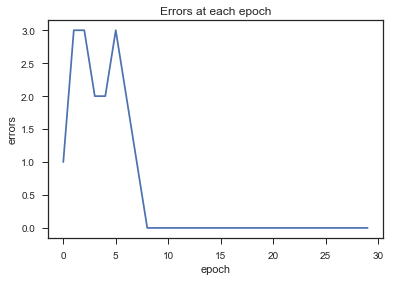

In [8]:
plt.figure()
xs = errors.keys()
ys = errors.values()
plt.xlabel('epoch')
plt.ylabel('errors')
plt.title('Errors at each epoch')
plt.plot(xs, ys)

(-1, 1)

(-1, 1)

Text(0.5,1,u'Separation boundary found')

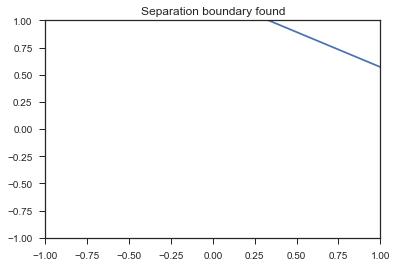

In [9]:
x_intersect = [0,-bias/w[1]]
y_intersect = [-bias/w[0],0]
plt.xlim([-1,1])
plt.ylim([-1,1])
plt.title('Separation boundary found')

plt.plot(x_intersect, y_intersect)

We can see the effect of using a smaller eta variable on the same training data:

Text(0.5,0,u'epoch')

Text(0,0.5,u'errors')

Text(0.5,1,u'Errors at each epoch')

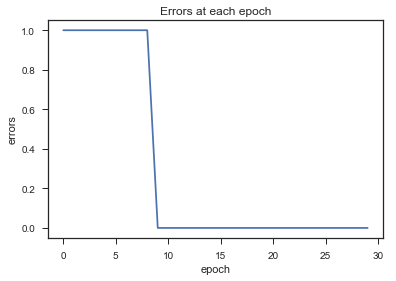

In [10]:
w, b, errors = train_perceptron(training_data, eta=0.05)

plt.figure()
xs = errors.keys()
ys = errors.values()
plt.xlabel('epoch')
plt.ylabel('errors')
plt.title('Errors at each epoch')
plt.plot(xs, ys)

Perceptrons have some limitations:

- They only converge for linearly separable problems, which most interesting problems are not
- Because they use a step function, we can't make small tweaks to their output - it's either 0 or 1

The way we deal with the first issue will be by building networks of neurons, where the output of one layer can be inputs to the next layer. This allows us to solve complex problems (or, mathematically - can approximate to an arbitrary accuracy any function). However this exasperates our second problem - without being able to tweak our perceptrons in a predictable way we're not going to be able to create a trainable network of them. 

For this reason, we change the non-linearity, that is the **activation function**. Our computed $\mathbf{x} \cdot \mathbf{w} + b$ doesn't need to change, but instead of using the inequality with 0, we pass this value to a different function.

# Sigmoid neurons

The sigmoid neuron uses the activation function $\sigma(z) = \frac{1}{1+e^-z}$, where z is our computed $\mathbf{x} \cdot \mathbf{w} + b$. Before we code this, we can examine its shape:

In [11]:
def sigmoid_fn(x):
    return 1/(1+np.exp(-x))

Text(0.5,1,u'Sigmoid')

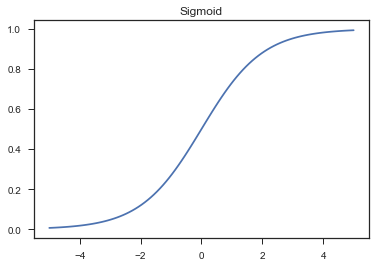

In [12]:
xs = np.linspace(-5,5,100) # 100 evenly spaced values between -5 and 5
ys = sigmoid_fn(xs)

plt.title('Sigmoid')
plt.plot(xs, ys)

Text(0.5,1,u'Step function')

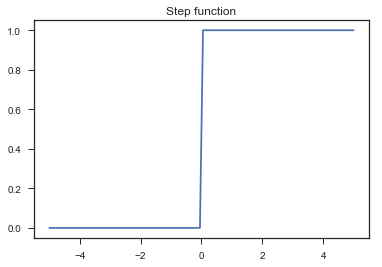

In [13]:
# Compare this to the step function:

def step(x):
    return 1 if x>0 else 0

xs = np.linspace(-5,5,100) # 100 evenly spaced values between -5 and 5
ys = [step(x) for x in xs]

plt.title('Step function')
plt.plot(xs, ys)

We can see that the sigmoid is a smoothed step function, maintaining the bounds of 0 and 1, but changing by only a small amount each time its input changes. This is the only difference between the sigmoid and perceptron, but it turns out to be significant. 

At this point it makes sense to generalise our code to define a neuron, with a view to eventually building up a neural network - that is, a network of layers of neurons. So let's define a neuron:

In [14]:
class Neuron:
    def __init__(self, num_inputs, activation_function):
        # We always initialise a neuron with random weights and bias
        # We must pass an activation function, as this is different for each type of neuron
        self.weights = np.random.rand(num_inputs)
        self.bias = np.random.rand()
        self.num_inputs = num_inputs # This will let us generalise updates
        self.activation_function = activation_function
        
    def _compute_value(self, xs):
        # Compute the value of the neuron for the given inputs
        return np.dot(xs, self.weights) + self.bias
    
    def get_value(self, xs):
        return self.activation_function(self._compute_value(xs))

Essentially, a neuron knows how to compute its value from its weights and bias term, and it has an activation function, which takes such a value and computes the desired output for the neuron. 

In [15]:
# So a perceptron is simply:
perceptron = Neuron(2, activation_function = step)
perceptron.get_value([0,0])

# And a sigmoid is simply:
sigmoid = Neuron(2, activation_function = sigmoid_fn)
sigmoid.get_value([0,0])

1

0.67212027700497834

Now we can re-implement our learning method using the generic neuron (and thus supporting any given activation function)

In [16]:
%%add_to Neuron
def train(self, training_data, epochs=30, eta=0.05):
    errors = {}

    for i in range(epochs):
        errors[i] = 0
        for X, y in training_data:
            output = self.get_value(X)
            error = y - output
            if np.absolute(error) > 0.5: # Not a binary output, so allow some difference here - as long as we're close
                errors[i]+=1

            # Update each weight in turn, and the bias
            for j in range(self.num_inputs):
                self.weights[j] += eta * error * X[j]
            self.bias += eta * error
    
    return errors

In [17]:
sigmoid = Neuron(2, activation_function = step) # Make sure we re-create the neuron to get the new method included
errors = sigmoid.train(training_data)

(-1, 1)

(-1, 1)

Text(0.5,1,u'Separation boundary found')

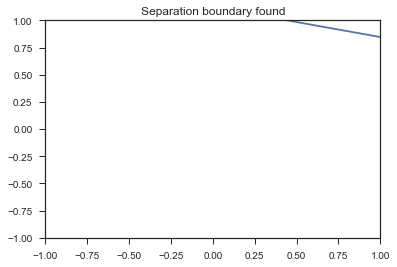

In [18]:
x_intersect = [0,-sigmoid.bias/sigmoid.weights[1]]
y_intersect = [-sigmoid.bias/sigmoid.weights[0],0]
plt.xlim([-1,1])
plt.ylim([-1,1])
plt.title('Separation boundary found')
plt.plot(x_intersect, y_intersect)

Text(0.5,0,u'epoch')

Text(0,0.5,u'errors')

Text(0.5,1,u'Errors at each epoch')

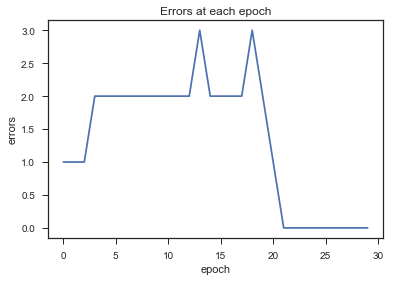

In [19]:
plt.figure()
xs = errors.keys()
ys = errors.values()
plt.xlabel('epoch')
plt.ylabel('errors')
plt.title('Errors at each epoch')
plt.plot(xs, ys)

# A layer of neurons: Naive

Like a perceptron, a sigmoid can only classify linearly separable problems. To solve general problems we need to have multiple layers of neurons - and because each neuron has a non-linear activation function this will provide us a non-linear system and allow us to approximate non-linearly separable (actually, all) functions. 

Let's first consider what a layer of neurons actually looks like, in the simplest way:

In [20]:
class Layer:     
    def __init__(self):
        self.neurons = []
    
    def add_neuron(self, neuron):
        self.neurons.append(neuron)
        
    def evaluate(self, xs):
        outputs = []
        for neuron in self.neurons:
            outputs.append(neuron.get_value(xs))
        
        return outputs

A layer of neurons just contains the neurons that have been added to it. It receives some input - just like a single neuron does - but its output contains the computed value of each neuron in the layer.

The way to think of this is as the layer receiving the output of the previous layer, or the inputs to the network as a whole. Then the outputs of this layer could be the outputs of the network as a whole, or they could be fed forward into the next layer. 

In each layer, every neuron receives as input the complete output of the last layer. We call these layers 'fully connected' or 'dense', and they're the only sort of layer we'll consider here. 

Consider a layer of 3 neurons:

In [21]:
layer = Layer()
for i in range(3): # Add 3 neurons
    sig = Neuron(4, activation_function = sigmoid_fn) # Each sigmoid takes 4 inputs
    layer.add_neuron(sig)

layer.evaluate([1,-4,3,-6]) # We can evaluate any 4 real numbers as input

for i in range(3): # Add 3 more neurons
    sig = Neuron(4, activation_function = sigmoid_fn) # Each sigmoid takes 4 inputs
    layer.add_neuron(sig)

layer.evaluate([1, 0, 1, -1])

[0.63927546131730062, 0.10394206357543584, 0.7142227884840896]

[0.79123954045821199,
 0.73652809007301012,
 0.79092631600289487,
 0.78585385751451298,
 0.46650300580988857,
 0.72385053662241239]

As we can see, our layer takes as input 4 values, and each of its neurons can take as input such a list. It evaluates to 3 outputs, because we added 3 neurons. When we add another 3 neurons for a total of 6, it evaluates to 6 outputs.

Clearly all of our neurons need to share the same number of inputs - the same input it passed to all of them when we evaluate them. A better API would enforce this constraint. I'm not sure if there's ever a reason to mix-and-match activation functions within a layer, but we're not going to do that here - so let's also make the activation function a parameter of the `Layer` and enforce that it's the same for all neurons. Here's a better API for a `Layer`:

In [22]:
class Layer:
    def __init__(self, num_inputs, num_neurons, activation_function):
        self.neurons = []
        for i in range(num_neurons):
            neuron = Neuron(num_inputs, activation_function)
            self.neurons.append(neuron)
            
    def evaluate(self, xs):
        outputs = []
        for neuron in self.neurons:
            outputs.append(neuron.get_value(xs))
        
        return outputs
    
layer = Layer(4, 3, sigmoid_fn)
layer.evaluate([1,2,3,4])

layer = Layer(4, 6, sigmoid_fn)
layer.evaluate([1,-1,1,-1])

[0.99624672771653033, 0.99816655499301243, 0.96206916142525001]

[0.4404247141405131,
 0.87778584626121636,
 0.72192514328866331,
 0.48597662305432704,
 0.71180662871226352,
 0.6186325681526359]

Notice that we've lost some power here - we can no longer add to a layer after it's been created. It'd be easy enough to add that back, but we won't need to do that here so we'll keep the simpler class going forward. 

# Representing a layer as a matrix

Recall what's happening when we compute the value of each neuron - we compute $\mathbf{w} \cdot \mathbf{x} + b$, and then we pass that to the activation function (eg. step or sigmoid).

If we say that $\mathbf{x}$, our input vector, is a column vector (which makes sense graphically if we vertically align neurons within a layer) of length $n$, then we know that $\mathbf{w}$ is also a vector of length $n$. If we say that $\mathbf{w}$ is a row vector (or we transpose it from a column vector so that it is), then we can compute the dot product by doing a matrix multiply of the two vectors.

For example, let's say that $\mathbf{w} = \begin{pmatrix}1 & 2 & 3\end{pmatrix}$ and $\mathbf{x} = \begin{pmatrix}5 \\ 10 \\ 2 \end{pmatrix}$, then we can compute their dot product $\mathbf{w} \cdot \mathbf{x} = \begin{pmatrix}1 & 2 & 3 \end{pmatrix} \cdot \begin{pmatrix}5 \\ 10 \\ 2\end{pmatrix}  = (1x5) + (2x10) + (3x2) = 31$

If we have a second neuron in the same layer (so receiving the same input $\mathbf{x}$), with weights $\mathbf{w'} = \begin{pmatrix}2 & -2 & 0\end{pmatrix}$, then we can say that $\mathbf{w'} \cdot \mathbf{x} = \begin{pmatrix}2 & -2 & 0\end{pmatrix} \cdot \begin{pmatrix}5 \\ 10 \\ 2 \end{pmatrix} = (2x5) + (-2x10) + (0x2) = -10$

Then we can say that the dot products for our layer are $\begin{pmatrix}31 \\ -10\end{pmatrix}$. Recall that the value (before the activation function) is $\mathbf{w} \cdot \mathbf{x} + b$ - so we need to deal with our bias terms. Suppose the first neuron had bias $b = 3$ and the second neuron $b' = 5$, then we can add the bias terms using vector addition: $\begin{pmatrix}31 \\ -10\end{pmatrix} + \begin{pmatrix}3 \\ 5\end{pmatrix} = \begin{pmatrix}34 \\ -5\end{pmatrix}$

And finally we apply the activation function, say for simplicity that these are perceptrons: $\begin{pmatrix} 1 \\
0\end{pmatrix}$

This works, but we haven't actually gained anything - we've just split adding our bias and passing through the activation function to the end, doing it after we've done each dot product - but we're still doing individual dot products, and then combining them into a vector we can add the bias terms to and then element-wise applying the activation function. It turns out that we can use matrix multiplication to compute all the neurons in the layer at the same time. We say that $\mathbf{W}$ is a matrix, where each row is the weights of a single neuron. So for the above 2-neuron layer:
$\mathbf{W} = \begin{pmatrix} 1 & 2 & 3 \\ 2 & -2 & 0 \end{pmatrix}$. Now, we use matrix multiplication: 
$\begin{pmatrix} 1 & 2 & 3 \\ 2 & -2 & 0 \end{pmatrix} \cdot \begin{pmatrix}5 \\ 10 \\ 2 \end{pmatrix} = \begin{pmatrix}31 \\ -10 \end{pmatrix}$

We then add our bias terms, and apply the activation function to each element as before. 

This gives us a different way to view a layer of our network, it's simply a matrix $\mathbf{W}$ and a vector $\mathbf{b}$ - we don't need to loop over all our neurons or even define them as their own objects. The matrix has one row for each neuron (representing its weights). The length of each neuron's weights (ie the number of columns) is equal to the input. If we say we have m inputs to our layer, and n neurons in the layer, then our matrix multiply $\mathbf{W} \cdot \mathbf{x}$ looks like $(nxm) \cdot (mx1) = (nx1)$. This is what we'd expect, and explains why our weight matrix must be that specific shape. Each layer takes as input a column vector, and outputs a column vector of a length determined by its number of neurons.

Of course, our last layer needs to have the expected output shape for the problem - and therefore has a known number of rows. We can control the number of neurons, and thus rows, in all other layers though.

In [23]:
# Rewriting our Layer using the matrix multiply form
class Layer:
        def __init__(self, num_inputs, num_neurons, activation_function):
            # Use initial random values with mean 0, variance 1
            # The shape of our weights is n x m, where m = num columns = num_inputs, and n=num rows = num_neurons
            variance = 2/float(num_inputs + num_neurons)
            # self.weights = np.random.normal(scale=variance, size=(num_neurons, num_inputs))    
            self.weights = np.random.randn(num_neurons, num_inputs)
            
            # The shape of bias is 1 row, with a column for each neuron - a row vector.
            # self.bias = np.random.random_sample(size=(num_neurons, 1))
            self.bias = np.random.randn(num_neurons, 1)
            
            self.activation_function = activation_function
            
        def evaluate(self, x):
            # First, matrix multiply `W` by `x`, ie. weights by activations
            wx = np.matmul(self.weights, x)
            
            # Add the bias term
            add_b = wx + self.bias
            
            # Pass through the activation function
            return self.activation_function(add_b)

layer = Layer(3, 2, sigmoid_fn)
x = np.array([1,2,3]).reshape(3,1)

layer.evaluate(x)

array([[ 0.00293468],
       [ 0.79043961]])

# From a layer to a network

Now we have everything that we need to define a simple feed-forward neural network consisting of dense layers of neurons: we'll include our input and output layers as a layer of neurons, and we can have any layers between them - we just need to make sure our dimensions all match up.

We won't consider our MNIST dataset in any detail yet, other than to say that it contains images of 28x28 greyscale pixels. One obvious way to represent this as an input would be as 28x28=784 values, with each representing the intensity of one pixel. Our job is to classify which number the image is a drawing of, a single digit 0-9. So our final layer will have 10 outputs representing the digits 0-9, each representing the probability that the image is that digit. We would predict that the drawing is the digit with the highest probability. We call all other layers (those that aren't the input or output layer) hidden layers, and we can choose how many of these we want, and how complex they should be. 

For example, if we wanted a single hidden layer with 40 neurons, then we'd need two layers of neurons:
- A layer that takes as input 784 values, and has 40 neurons, and thus outputs 40 values - our hidden layer
- A layer that takes as input 40 values, and has 10 neurons, and thus outputs 10 values - our output layer

We'd generate predictions by evaluating the hidden layer with the input of 784 values, and then evaluating the output layer with the input of 40 values resulting from that. 

If we wanted to have two hidden layers with 50 and 110 neurons respectively, then we'd need three layers of neurons:
- A layer that takes as input 784 values, and has 50 neurons, and thus outputs 50 values - our first hidden layer
- A layer that takes as input 50 values, and has 110 neurons, and thus outputs 110 values - our second hidden layer
- A layer that takes as input 110 values, and has 10 neurons, and thus outputs 10 values - our output layer

In [24]:
# Let's see how a network looks in practice
class Network:
    def __init__(self):
        self.layers = []
        
    def add_layer(self, layer):
        self.layers.append(layer)
        
    def evaluate(self, x):
        value = x
        for layer in self.layers:
            value = layer.evaluate(value)
        
        return value

This looks very similar to our first attempt at a `Layer`, but this time we won't simplify any further: we want to permit any layer to be used in our network (so a network can contain layers with different activation functions), and additionally as each layer has a non-linearity (the activation function) we can't simplify the computation any further.

In [25]:
# Our examples of networks from above, using sigmoids:
net1 = Network()
net1.add_layer(Layer(784, 40, sigmoid_fn)) # Hidden layer
net1.add_layer(Layer(40, 10, sigmoid_fn)) # Output layer

net2 = Network()
net2.add_layer(Layer(784, 50, sigmoid_fn)) # First hidden layer
net2.add_layer(Layer(50, 110, sigmoid_fn)) # Second hidden layer
net2.add_layer(Layer(110, 10, sigmoid_fn))

In [26]:
x = np.random.random_sample(size=(784,1))

net1.evaluate(x)
net2.evaluate(x)

array([[ 0.02918203],
       [ 0.09738879],
       [ 0.99915849],
       [ 0.79399229],
       [ 0.54112851],
       [ 0.40924219],
       [ 0.89086332],
       [ 0.99958235],
       [ 0.07366674],
       [ 0.99334683]])

array([[  7.77114114e-05],
       [  9.18464620e-01],
       [  1.08966035e-01],
       [  9.93263256e-04],
       [  2.61861338e-02],
       [  5.13990728e-02],
       [  1.75906737e-01],
       [  2.21376280e-01],
       [  8.53178800e-01],
       [  9.80263013e-01]])

# Training the network

At this point we've got everything that we need to build a network, made of layers of neurons - to compute any classification problem. We do this by feeding the input through the layers, so we call this a feed-forward network. The problem we have now is training it: we can be given inputs and known outputs, we can pass it the input and observe the output, but we don't yet have a way to adjust the weights. We can't update them like we did for a single neuron - that doesn't capture our more subtle relationship between neurons within our network. 

This is where backpropagation comes in.

In [27]:
# Our activation function needs to be differentiable
class Sigmoid_cls:
    def __init__(self):
        pass
    
    def compute(self, z):
        return 1/(1+np.exp(-z))
    
    def derivative(self, z):
        return self.compute(z)*(1-self.compute(z))

In [28]:
# We introduce a cost function, also differentiable (quadratic cost function)
class QuadraticCost_cls:
    def __init__(self):
        pass
    
    def compute(self, computed, desired):
        # Quadratic cost of a single training example
        return ((computed - desired) ** 2).mean(axis=None)
    
    def derivative(self, computed, desired):
        # Derivative of the compute function, returned as an array
        return (computed - desired)

In [29]:
%%add_to Layer
# Backprop is simpler if we calculate both the weighted input z(x) ie wx + b, as well as f(z(x)) ie sigmoid
# So modify layer:
def weighted_input(self, x):
    # First, matrix multiply `W` by `x`, ie. weights by activation
    wx= np.matmul(self.weights, x)
            
    # Add the bias term
    add_b = wx + self.bias
    
    # We return without applying the activation function
    return add_b

def evaluate(self, xs):
    # Pass the weighted input through the activation function
    return self.activation_function.compute(self.weighted_input(xs))

In [30]:
%%add_to Network
# Add the cost function as a value of the network
def __init__(self, cost_function):
    self.layers = []
    self.cost_function = cost_function

# Notes

- We split the forward pass to return z(x), and then pass on f(z(x))


In [31]:
%%add_to Network
def backprop(self, network_input, desired_output):
    gradient_b = [np.zeros(layer.bias.shape) for layer in self.layers] # layer-by-layer gradients wrt biases
    gradient_w = [np.zeros(layer.weights.shape) for layer in self.layers] # layer-by-layer gradients wrt weights
    
    # Feedforward - pass the input through the current network, same effect as evaluate
    activation = network_input # Current activation passing through
    activations = [network_input] # Activations, per layer, starting from input
    weighted_inputs = [] # Weighted inputs, per layer, starting from first non-input layer. Stored for backward pass.
    for layer in self.layers:
        z = layer.weighted_input(activation)
        weighted_inputs.append(z)
        activation = layer.activation_function.compute(z)
        activations.append(activation)
    
    # Backward pass - propagate errors backward
    
    # First we deal with the last layer
    # Last layer is special because:
    # 1) It can compare its actual output to the desired output (the others all feed through more layers first)
    # 2) It doesn't have any layers after it to feed into
    last_layer = self.layers[-1]
    last_weighted_input = weighted_inputs[-1]
    network_output = activations[-1]   
    previous_activations = activations[-2]
    
    activation_derivative = last_layer.activation_function.derivative(last_weighted_input)
    cost_derivative = self.cost_function.derivative(network_output, desired_output)
    delta = activation_derivative * cost_derivative
    
    # Delta is the shape of our last layer (since both its components are), which perfectly matches its biases
    gradient_b[-1] = delta
    
    # The weights in the last layer are matrix multiplied with the activations in the previous layer 
    # as part of computing the weighted input. 
    # We do the same here to find the gradient, but we must transpose it for the matrix multiply to 
    # have the right shape (that of the last layer weights)
    # eg. If the last layer is 2 neurons, and the second to last is 5, then our weights are shape (2,5)
    # delta is (2,1) and activations before are (5,1), transposed to (1,5)
    gradient_w[-1] = np.matmul(delta, previous_activations.transpose())
    
    # Then we deal with each other layer, moving backward
    # Using negative indices to count backward, so this is from 2nd-to-last layer to first layer
    # When we index backward we count from 1 (ie last layer is -1), so first layer is at [-len(layers)]
    # and range excludes the end point so we add 1 to include that first layer
    for this_l in range(2, len(self.layers)+1):
        this_layer = self.layers[-this_l]
        this_weighted_input = weighted_inputs[-this_l]
        layer_after_weights = self.layers[-this_l+1].weights # The weights of the layer after this one when going forward  
        previous_activations = activations[-this_l-1] # We included input layer in activations
        
        previous_delta = delta # Same shape as the layer after this one
        activation_derivative = this_layer.activation_function.derivative(this_weighted_input) # Same shape as this layer
        
        # We can't use the network cost function here, because we don't know exactly our target output,
        # only the gradient we've computed for the layer after this one. We can find that cost though:
        
        # If we say that this layer has m neurons and the layer after this has m', then we know that 
        # the weights of the layer after this are shape (m', m)
        # We know that the previous delta was shape (m', 1) - the shape of the layer after this
        # Our cost is a function of these, and needs to be of the same shape as our activation function,
        # which is (m, 1)
        # So we matrix multiply the transpose of the weights (m, m') by the previous delta (m', 1), which gives
        # us the correct shape.
        cost_derivative = np.matmul(layer_after_weights.transpose(), previous_delta)
        
        delta = activation_derivative * cost_derivative
        
        # Again, delta is the shape of this layer since both its components are
        gradient_b[-this_l] = delta
        
        # And again we matrix multiply it with the activations in the layer before
        # to match the weights at this layer
        gradient_w[-this_l] = np.dot(delta, previous_activations.transpose())

    # print activations[-1] # We'll comment this out if it gets annoying, but it's a useful illustration
    # print self.cost_function.compute(activations[-1], desired_output) # ^ Same with this
    # print
    return (gradient_b, gradient_w)

In [32]:
# A very simple example, building up a network and training it to map a column [1,2,3,4] to a column [1,0]
# This is an example of classification, in this case [1,2,3,4] is in the first class

net1 = Network(QuadraticCost_cls())
net1.add_layer(Layer(4, 5, Sigmoid_cls())) # Hidden layer
net1.add_layer(Layer(5, 10, Sigmoid_cls())) # Hidden layer
net1.add_layer(Layer(10, 30, Sigmoid_cls())) # Hidden layer
net1.add_layer(Layer(30, 2, Sigmoid_cls())) # Output layer

x = np.array([1,2,3,4]).reshape(4,1)
y = np.array([1,0]).reshape(2,1)

# This is basic gradient descent - backprop gives us the gradient for weights and biases, we descent in that direction
for i in range(200):
    g_b, g_w = net1.backprop(x,y)
    for j in range(len(net1.layers)):
        layer = net1.layers[j]
        layer.weights -= g_w[j]
        layer.bias -= g_b[j]

# Stochastic gradient descent

If we have more than one training example, then we'll need a way to update the weights such that our cost function decreases by as much as possible over all of them - like with the perceptron. 

The batch gradient descent algorithm would involve computing the gradient (using backpropagation) for all training examples, and then updating it once - and then repeating that process for however many epochs we want to teach the network for. This uses a lot of memory and means we only descend the cost function after computing for all the training examples, and we can be liable to get stuck at a local minima. 

In stochastic gradient descent we instead descend the cost function after each individual training example. This is noisy but it still converges to the minima, and sometimes more noise is beneficial for escaping local minima. 
We actually used basically this for training our perceptron:
```
for x, y in training_data:
    # Find error
    w[0] += eta * error * x[0]
    w[1] += eta * error * x[1]
    bias += eta * error
```

Notice we update the weights and bias terms inside the loop over each training example. This is stochastic gradient descent. 

A compromise solution is the minibatch one, where we group our training data into batches on which we perform batch gradient descent sequentially. For example we might update the weights after every 64 training examples. This is much more efficient than stochastic gradient descent, but still has some noise and more regular descents than the pure batch method. 

In [33]:
net1 = Network(QuadraticCost_cls())
net1.add_layer(Layer(4, 5, Sigmoid_cls())) # Hidden layer
net1.add_layer(Layer(5, 10, Sigmoid_cls())) # Hidden layer
net1.add_layer(Layer(10, 30, Sigmoid_cls())) # Hidden layer
net1.add_layer(Layer(30, 2, Sigmoid_cls())) # Output layer

x1 = np.array([1,2,3,4]).reshape(4,1)
y1 = np.array([1,0]).reshape(2,1)

x2 = np.array([4,3,2,1]).reshape(4,1)
y2 = np.array([0,1]).reshape(2,1)

# This is basic gradient descent - backprop gives us the gradient for weights and biases, we descent in that direction
for i in range(200):
    g_b1, g_w1 = np.array(net1.backprop(x1,y1))
    g_b2, g_w2 = np.array(net1.backprop(x2,y2))
    
    diff_b, diff_w = (g_b1+g_b2)/2, (g_w1+g_w2)/2
    
    for j in range(len(net1.layers)):
        layer = net1.layers[j]
        layer.weights -= diff_w[j]
        layer.bias -= diff_b[j]
        
net1.evaluate(x1)
net1.evaluate(x2)

array([[ 0.96219629],
       [ 0.04933536]])

array([[ 0.03795071],
       [ 0.95099111]])

We'll create a simple toy dataset of 500 examples, where each example has an input of shape (2,1) and each output has a shape (2,1)

Our input values will all be between 0-1, and our target outputs will all be (1,0) or (0,1), ie another simple classification. 

We'll use completely random input values, and evenly split the target output between (1,0) and (0,1). This might not work very well because we're not giving the network any inherent structure to learn, but it lets us work with a slightly larger dataset. 

Note: Might want to change this to have a rule, eg x[0]<=0.5 => y[0]=1 (maybe only do that afterward to introduce a test set)

In [55]:
def generate_toy_dataset(num_examples = 500):
    examples_per_class = int(num_examples/2)
    dataset = []
    
    for i in range(0, examples_per_class):
        x = np.array([np.random.rand()/2, np.random.rand()]).reshape(2,1)
        y = np.array([1,0]).reshape(2,1)
        dataset.append((x,y))
    
    for i in range(0, examples_per_class):
        x = np.array([(np.random.rand()/2)+0.5, np.random.rand()]).reshape(2,1)
        y = np.array([0,1]).reshape(2,1)
        dataset.append((x,y))
        
    return dataset
    
dataset = generate_toy_dataset()

In [56]:
def create_mini_batches(dataset, batch_size=64):
    num_batches = (len(dataset)//batch_size) + 1 # Floor division, +1
    
    mini_batches = []
    at = 0
    for i in range(num_batches):
        mini_batch = dataset[at:at+64]
        mini_batches.append(mini_batch)
        at += 64
    
    return mini_batches

In [57]:
net1 = Network(QuadraticCost_cls())
mini_batches = create_mini_batches(dataset)
print len(mini_batches)
print len(mini_batches[0])
print len(mini_batches[7])
print mini_batches[0][0]

8
64
52
(array([[ 0.29049663],
       [ 0.93263369]]), array([[1],
       [0]]))


In [58]:
def update_mini_batch(network, mini_batch, eta=0.1, p=False):
    gradient_b = [np.zeros(layer.bias.shape) for layer in network.layers] # layer-by-layer gradients wrt biases
    gradient_w = [np.zeros(layer.weights.shape) for layer in network.layers] # layer-by-layer gradients wrt weights

    for x,y in mini_batch:
        delta_gradient_b, delta_gradient_w = network.backprop(x,y)

        for i in range(len(network.layers)):
            gradient_b[i] += delta_gradient_b[i]
            gradient_w[i] += delta_gradient_w[i]
            
    # After all the training examples, apply the gradient change to the network
    for i in range(len(network.layers)):
        layer = network.layers[i]
        layer.weights -= (gradient_w[i] * eta/len(mini_batch))
        layer.bias -= (gradient_b[i] * eta/len(mini_batch))

The final piece to put all this together is some kind of evaluation function. We could use the cost function, but it's simpler to treat this as classification - we'll choose the larger output as our class, and see how many we get right.

In [59]:
def evaluate(network, test_data):
    num_correct = 0
    for x,y in test_data:

        network_output = network.evaluate(x)
        
        #print network_output
        
        chosen_class = np.argmax(network_output)
        expected_class = np.argmax(y)
        if chosen_class == expected_class:
            num_correct += 1
            
    return num_correct

In [60]:
def SGD(network, training_data, num_epochs=20, eta=1):
    np.random.shuffle(training_data)
    
    mini_batches = create_mini_batches(training_data, batch_size=64) 
    
    for i in range(num_epochs):
    
        for mini_batch in mini_batches:
            update_mini_batch(net1, mini_batch, eta, i==1)
            
        # Evaluate the network on the training data
        num_correct = evaluate(network, training_data)
        print(num_correct)

In [61]:
# Add some layers to the network
net1 = Network(QuadraticCost_cls())
net1.add_layer(Layer(2, 10, Sigmoid_cls())) # Hidden layer
net1.add_layer(Layer(10, 2, Sigmoid_cls())) # Output layer

dataset = generate_toy_dataset(num_examples=500)
SGD(net1, dataset, eta=1)

250
327
373
406
427
439
446
449
455
460
462
463
464
468
469
471
473
475
477
480


Evaluating on our training set after each epoch lets us see how it's performing, but what we're really interested in is the performance on data that the network hasn't been trained on. We'll generate a smaller test data set and score the network on those after each epoch.

In [70]:
def to_percent(correct, total):
    return correct/total*100

def SGD(network, training_data, test_data=None, num_epochs=20, eta=1):
    np.random.shuffle(training_data)
    
    if not test_data:
        print "WARN: test data not given, so scoring on training data"
        test_data = training_data # Score on the training data if we don't have test data
        
    test_count = len(test_data)
    
    mini_batches = create_mini_batches(training_data, batch_size=64)
    
    for i in range(num_epochs):
    
        for mini_batch in mini_batches:
            update_mini_batch(net1, mini_batch, eta, i==1)
            
        # Evaluate the network on the training data
        num_correct = evaluate(network, test_data)
        print "Epoch %d complete: %d/%d (%d %)" % (i+1, num_correct, test_count, to_percent(num_correct, test_count))

In [71]:
# Add some layers to the network
net1 = Network(QuadraticCost_cls())
net1.add_layer(Layer(2, 10, Sigmoid_cls())) # Hidden layer
net1.add_layer(Layer(10, 2, Sigmoid_cls())) # Output layer

train_data = generate_toy_dataset(num_examples=500)
test_data = generate_toy_dataset(num_examples=100)
SGD(net1, train_data, test_data, eta=1)

TypeError: not enough arguments for format string